# DDA - Label-Free

This tutorial demonstrates how to analyze label-free quantification data from data-dependent acquisition (DDA) using the `msmu` package.

## Data Preparation

Original dataset is from [PXD012986](https://www.ebi.ac.uk/pride/archive/projects/PXD012986) (Uszkoreit _et al_., 2022) and search was performed with [`Sage` v0.14.7](https://github.com/lazear/sage/tree/v0.14.7).

For demonstration purposes, the example dataset was reduced to six samples and a total of 5,000 PSMs.


In [1]:
base_dir = "https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq"
sage_idents = f"{base_dir}/sage/results.sage.tsv"
sage_quants = f"{base_dir}/sage/lfq.tsv"
meta = f"{base_dir}/meta.csv"

## Load Required Packages

> If you haven't installed the `msmu` package yet, please follow the [installation guide](../../installation/).


In [2]:
import msmu as mm
import pandas as pd
import plotly.io as pio

pio.renderers.default = "png"

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Read Data

You can read data from various proteomics software outputs. Below are examples for `Sage`, `MaxQuant`, and `FragPipe` formats.

For this tutorial, we will use the `Sage` output as an example.

`read_sage()` function reads the `Sage` output files (`lfq.tsv`, `results.sage.tsv`) and creates modalities at MuData object.


In [3]:
# Sage format
mdata = mm.read_sage(identification_file=sage_idents, quantification_file=sage_quants, label="label_free")

# MaxQuant format
# mdata = mm.read_maxquant(identification_file="path_to_maxquant_output", label="label_free", acquisition="dda")

# FragPipe format
# mdata = mm.read_fragpipe(identification_file="path_to_fragpipe_output", label="label_free", acquisition="dda")

INFO - Identification file loaded: (5000, 40)
INFO - Quantification file loaded: (3578, 12)
INFO - Decoy entries separated: (345, 13)


In [4]:
mdata

MuData object with n_obs × n_vars = 6 × 8233
  2 modalities
    psm:	6 x 4655
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy'
      varm:	'search_result'
    peptide:	6 x 3578
      uns:	'level'

### Adding Metadata

Optionally, you can add metadata for samples to the `mdata.obs` dataframe. Make sure that the index of the metadata dataframe matches the sample names in `mdata.obs`.


In [5]:
meta_df = pd.read_csv("https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/dev/data/sage_lfq/meta.csv")
meta_df = meta_df.set_index("sample_id")  # set the index to match sample id in mdata.obs

mdata.obs = mdata.obs.join(meta_df)
mdata.push_obs()  # update all modalities with the new obs data
mdata.obs

,set,sample_name,condition,replicate
QExHF04026,S1,G1-1,G1,1
QExHF04028,S1,G2-1,G2,1
QExHF04036,S1,G1-2,G1,2
QExHF04038,S1,G2-2,G2,2
QExHF04046,S1,G1-3,G1,3
QExHF04048,S1,G2-3,G2,3


## Handling PSM level

### Filtering - PSM

You can filter the data based on the column values, such as q-value.
You can also filter the data based on string containment, which can be useful for removing contaminants or decoys.

Filtering is split into two steps: first, you mark a filter condition using `mm.pp.add_filter()`, and then you apply the filter using `mm.pp.apply_filter()`.

Here, we keep protein groups with q-value < 0.01 and remove contaminants (protein IDs containing "contam\_").


In [6]:
mdata = mm.pp.add_filter(mdata, modality="psm", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.add_filter(mdata, modality="psm", column="proteins", keep="not_contains", value="contam_")
mdata = mm.pp.apply_filter(mdata, modality="psm")

mdata

MuData object with n_obs × n_vars = 6 × 7837
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  2 modalities
    psm:	6 x 4259
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3578
      obs:	'set', 'sample_name', 'condition', 'replicate'
      uns:	'level'

## Handling peptide level

### Summarisation - peptide

You can summarise psm-level data to peptide-level data using the `mm.pp.to_peptide()` function.


In [7]:
mdata = mm.pp.to_peptide(mdata)

INFO - Peptide-level identifications: 3634 (3615 at 1% FDR)


Using existing peptide quantification data.


### Filtering - peptide


In [8]:
mdata = mm.pp.add_filter(mdata, modality="peptide", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="peptide")

mdata

MuData object with n_obs × n_vars = 6 × 7874
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  2 modalities
    psm:	6 x 4259
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3615
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

### Normalisation

Here, we log2 transform and normalise the data at the peptide level.

Median centering normalisation is applied using `mm.pp.normalise()` function.


In [9]:
mdata = mm.pp.log2_transform(mdata, modality="peptide")
mdata = mm.pp.normalise(mdata, modality="peptide", method="median")

### Protein inference

You can infer protein-level data from peptide-level data using the `mm.pp.infer_protein()` function.


In [10]:
mdata = mm.pp.infer_protein(mdata)

INFO - Starting protein inference
INFO - Initial proteins: 3651
INFO - Removed indistinguishable: 1586
INFO - Removed subsettable: 539
INFO - Removed subsumable: 2
INFO - Total protein groups: 1524


## Handling protein level

### Summarisation - protein

You can summarise peptide-level data to protein-level data using the `mm.pp.to_protein()` function.

As default, top 3 peptides within protein group can be used for protein group quantification aggregation. If top_n is None, all peptides will be used.


In [11]:
mdata = mm.pp.to_protein(mdata, top_n=3, rank_method="total_intensity")

INFO - Ranking features by 'total_intensity' to select top 3 features.
INFO - Protein-level identifications :  1489 (1463 at 1% FDR)


### Filtering - protein


In [12]:
mdata = mm.pp.add_filter(mdata, modality="protein", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="protein")

mdata

MuData object with n_obs × n_vars = 6 × 9337
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  3 modalities
    psm:	6 x 4259
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3615
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
    protein:	6 x 1463
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

## Visualisation

### ID plot


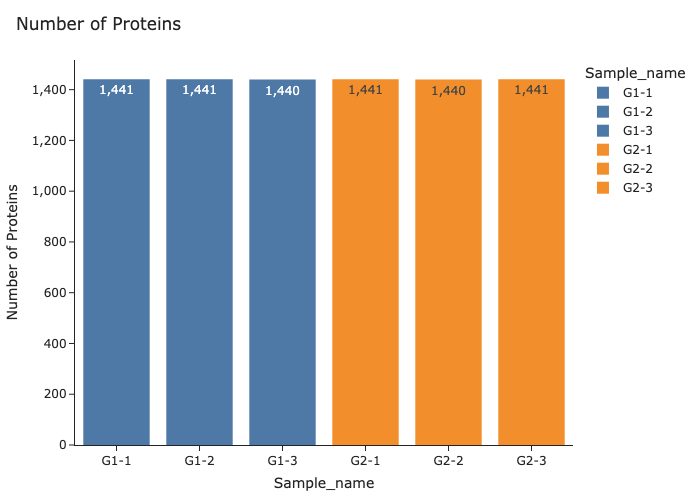

In [13]:
mm.pl.plot_id(mdata, modality="protein", colorby="condition", obs_column="sample_name")

### Intensity distribution plot


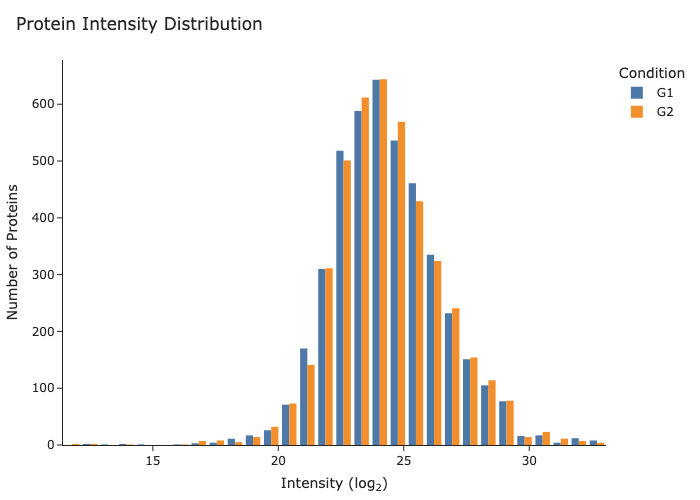

In [14]:
mm.pl.plot_intensity(mdata, modality="protein", groupby="condition", obs_column="sample_name")

## Save Data

You can save MuData object into an H5MU file.


In [15]:
mdata.write_h5mu("dda_lfq_PXD012986.h5mu")

## Citation

> Uszkoreit, J., Barkovits, K., Pacharra, S., Pfeiffer, K., Steinbach, S., Marcus, K., & Eisenacher, M. (2022). Dataset containing physiological amounts of spike-in proteins into murine C2C12 background as a ground truth quantitative LC-MS/MS reference. _Data in Brief_, 43, 108435.

> Lazear, M. R. (2023). Sage: an open-source tool for fast proteomics searching and quantification at scale. _Journal of Proteome Research_, 22(11), 3652-3659.
